## Using this Notebook

We use the RCMAP fractional shrub cover dataset (2000–2020) to quantify shrub cover inside the Cedar Fire area over time.

### Step 0: Load stored variables
- From previous notebooks call stored variables.
### Step 1: Libraries
- Import required libraries.
### Step 2: Point to the RCMAP shrub zip and read it
- Here we are using the (`NLCD_shrub_2000_2020.zip`) in `data/raw/landcover`.
### Step 3: Open and inspect the RCMAP data and build the shrub raster
- Build the shrub dataframes
### Step 4: For each Cedar Fire phase (pre- & post-) calculate summary statistics
- Load the shrub raster for that year from the zip.
- Reproject and clip it to the Cedar Fire boundary.
- Calculate summary shrub statistics (e.g., mean shrub cover).
### Step 5: Create a timeseries dataframe
- Combine pieces from previous step to prepare the dataframe for visualization
### Step 6: Save figures and csv summaries
- Save the shrub maps we made
- As we are now processing raw data, there is a new directory under data called 'processed' where csv are stored
### Step 7: Store key variables for use in later land cover and RCMAP notebooks.


### Step 0: Load stored variables

In [2]:
%store -r

### Step 1: Libraries

In [3]:
# Import libraries
from pathlib import Path
import zipfile
import re

import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.windows import from_bounds
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import requests
from shapely.geometry import box

In [4]:
# Check that our storing worked
print("Cedar CRS:", cedar_3310.crs)
print("Target CRS:", target_crs)
print("NLCD_CLASSES keys:", sorted(NLCD_CLASSES.keys()))
print("CEDAR_YEARS:", CEDAR_YEARS)

Cedar CRS: EPSG:3310
Target CRS: EPSG:3310
NLCD_CLASSES keys: [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 81, 82, 90, 95]
CEDAR_YEARS: {'pre_fire': [2000, 2001, 2002], 'fire_year': [2003], 'post_fire': [2004, 2005, 2010, 2015, 2020]}


In [5]:
# Make sure these are Path objects (in case Jupyter stored them as strings)

PROJECT_ROOT = Path(PROJECT_ROOT)
DATA_DIR = Path(DATA_DIR)
BOUNDARY_DIR = Path(BOUNDARY_DIR)
LANDCOVER_DIR = Path(LANDCOVER_DIR)

# Folder to hold the big RCMAP shrub zip bundles
RCMAP_ZIP_DIR = LANDCOVER_DIR / "rcmap_bundles"
RCMAP_ZIP_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_DIR, LANDCOVER_DIR, RCMAP_ZIP_DIR

(WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery'),
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data'),
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover'),
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover/rcmap_bundles'))

### Step 2: Point to the shrub data zip and read it
So because we are using two very large file for this portion (about 80GB) in total, we will need to break down reading the shrub data into a few steps. In first part of step 2 we will build out a download helper. This helper will help us when we request the RCMAP shrub data from MLRC. Essentially is a resumable downloader, so if the download gets interrupted it will start from where it left off. 

Once we download the files we unzip and read them.

In [6]:
# Function helper
def download_with_resume(url, dest_path, chunk_size=1024 * 1024):
    """
    Download a large file with resume support.
    If a .part file exists, it resumes from where it left off.
    """
    dest_path = Path(dest_path)
    tmp_path = dest_path.with_suffix(dest_path.suffix + ".part")

    headers = {}
    mode = "wb"

    if tmp_path.exists():
        existing_size = tmp_path.stat().st_size
        headers["Range"] = f"bytes={existing_size}-"
        mode = "ab"
        print(f"Resuming download at ~{existing_size / 1e6:.1f} MB")

    print(f"Requesting: {url}")
    with requests.get(url, stream=True, headers=headers) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0)) or None
        downloaded = tmp_path.stat().st_size if tmp_path.exists() else 0

        with open(tmp_path, mode) as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total:
                        pct = downloaded / total * 100
                        print(f"\rDownloaded ~{downloaded / 1e6:6.1f} MB ({pct:5.1f}%)", end="")
        print()  # newline after progress

    tmp_path.rename(dest_path)
    print(f"Finished: {dest_path}")


In [7]:
# Pull shrub data from MRLC
MRLC_BASE = "https://www.mrlc.gov"

shrub_urls = {
    "Shrub_1998_2010": f"{MRLC_BASE}/downloads/sciweb1/shared/mrlc/data-bundles/Shrub_1998_2010.zip",
    "Shrub_2011_2024": f"{MRLC_BASE}/downloads/sciweb1/shared/mrlc/data-bundles/Shrub_2011_2024.zip",
}

for name, url in shrub_urls.items():
    dest = RCMAP_ZIP_DIR / f"{name}.zip"
    
# For if the code/kernel needs to be reset/rerun: skip if already downloaded
    if dest.exists():
        print(f"\n✔ {name}.zip already exists — skipping download.")
        continue

    print(f"\n=== Downloading {name} ===")
    download_with_resume(url, dest)


✔ Shrub_1998_2010.zip already exists — skipping download.

✔ Shrub_2011_2024.zip already exists — skipping download.


In [8]:
import zipfile
import shutil

# Folder where extracted shrub rasters will live
RCMAP_SHRUB_DIR = LANDCOVER_DIR / "rcmap_shrub"
RCMAP_SHRUB_DIR.mkdir(parents=True, exist_ok=True)

def safe_unzip(zip_path, extract_dir):
    """
    Unzip a very large MRLC bundle safely and only once.
    - Skips if target folder already exists.
    - Handles messy internal folder names by flattening structure.
    """
    zip_path = Path(zip_path)
    
    # Create a clean folder inside rcmap_shrub using the ZIP's base name
    target_dir = extract_dir / zip_path.stem
    target_dir.mkdir(parents=True, exist_ok=True)

    # If the folder already contains files, skip extraction
    if any(target_dir.iterdir()):
        print(f"✔ {zip_path.name} already extracted to {target_dir} — skipping.")
        return target_dir
    
    print(f"Extracting {zip_path.name} ... this may take several minutes.")

    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

    print(f"✔ Finished extracting {zip_path.name} → {target_dir}")
    return target_dir


# ---- Unzip both shrub bundles ----
bundle_paths = [
    RCMAP_ZIP_DIR / "Shrub_1998_2010.zip",
    RCMAP_ZIP_DIR / "Shrub_2011_2024.zip",
]

for bundle in bundle_paths:
    safe_unzip(bundle, RCMAP_SHRUB_DIR)

print("\nAll shrub bundles processed.")


✔ Shrub_1998_2010.zip already extracted to C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010 — skipping.
✔ Shrub_2011_2024.zip already extracted to C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_2011_2024 — skipping.

All shrub bundles processed.


### Step 3: Open and inspect the data and build the shrub raster
Now that we processed the zip file, we will read each year to make sure we have 1 shrub file for each year. We then will build out the clipped raster dataframe and call a single year (and print it) to ensure we have the dataframe in the right projection, and that the shurb cover range [0, 100] appears correctly.

In [ ]:
import re

# RCMAP_SHRUB_DIR was defined in Cell 5:
# RCMAP_SHRUB_DIR = LANDCOVER_DIR / "rcmap_shrub"

def find_rcmap_year_rasters(rcmap_shrub_dir):
    """
    Walk through the extracted shrub folders and group rasters by year.
    Returns a dict: {year (int): [list of Path objects]}.
    """
    rcmap_shrub_dir = Path(rcmap_shrub_dir)
    year_pattern = re.compile(r"(19|20)\d{2}")

    year_files = {}

    for tif_path in rcmap_shrub_dir.rglob("*.tif"):
        match = year_pattern.search(tif_path.name)
        if not match:
            print(f"No year found in filename, skipping: {tif_path.name}")
            continue

        year = int(match.group(0))
        year_files.setdefault(year, []).append(tif_path)

    return year_files

# Build the mapping
RCMAP_YEAR_FILES = find_rcmap_year_rasters(RCMAP_SHRUB_DIR)

# Quick sanity check: what years did we find, and how many files per year?
print("Years found in shrub bundles:")
for yr in sorted(RCMAP_YEAR_FILES.keys()):
    print(f"  {yr}: {len(RCMAP_YEAR_FILES[yr])} file(s)")


Years found in shrub bundles:
  1998: 1 file(s)
  1999: 1 file(s)
  2000: 1 file(s)
  2001: 1 file(s)
  2002: 1 file(s)
  2003: 1 file(s)
  2004: 1 file(s)
  2005: 1 file(s)
  2006: 1 file(s)
  2007: 1 file(s)
  2008: 1 file(s)
  2009: 1 file(s)
  2010: 1 file(s)
  2011: 1 file(s)
  2012: 1 file(s)
  2013: 1 file(s)
  2014: 1 file(s)
  2015: 1 file(s)
  2016: 1 file(s)
  2017: 1 file(s)
  2018: 1 file(s)
  2019: 1 file(s)
  2020: 1 file(s)
  2021: 1 file(s)
  2022: 1 file(s)
  2023: 1 file(s)
  2024: 1 file(s)


In [ ]:
import rasterio
from rasterio import mask
import numpy as np

# ------------------------------------------------------------------
# 1. Make sure we have cedar_3310 in memory and in the target CRS
# ------------------------------------------------------------------

print("target_crs:", target_crs)
print("Cedar crs:", cedar_3310.crs)
print("Cedar bounds:", cedar_3310.total_bounds)

# ------------------------------------------------------------------
# 2. Function to load + clip RCMAP shrub for a given year
# ------------------------------------------------------------------
def load_and_clip_rcmap_year(year, boundary_gdf):
    """
    Load the RCMAP shrub raster for a given year and clip it to the given boundary.

    Returns:
      - band (2D numpy array, shrub cover with NaNs where nodata or out-of-range)
      - transform (affine transform for the clipped raster)
      - meta (raster metadata dict, updated for the clip)
    """
    tif_list = RCMAP_YEAR_FILES.get(year)
    if not tif_list:
        raise ValueError(f"No RCMAP rasters found for year {year}")

    # We have exactly 1 file per year, so take the first
    tif_path = tif_list[0]
    print(f"\n=== Loading RCMAP shrub for {year} ===")
    print(f"Using file: {tif_path}")

    with rasterio.open(tif_path) as src:
        print("RCMAP CRS:", src.crs)
        print("RCMAP bounds:", src.bounds)
        print("RCMAP nodata:", src.nodata)

        # Reproject boundary to raster CRS
        boundary_in_raster_crs = boundary_gdf.to_crs(src.crs)

        # Clip raster to boundary
        out_img, out_transform = mask.mask(
            src,
            boundary_in_raster_crs.geometry,
            crop=True
        )
        out_meta = src.meta.copy()

    # out_img shape: (bands, rows, cols). We have 1 band, so take index 0.
    data = out_img.astype("float32")
    nodata = out_meta.get("nodata", None)

    # Work on the single band
    band = data[0]

    # 1) Replace nodata with NaN
    if nodata is not None:
        band[band == nodata] = np.nan

    # 2) Enforce valid shrub percentage range (0–100)
    band[band < 0] = np.nan
    band[band > 100] = np.nan

    # Put cleaned band back into data array (for consistency)
    data[0] = band

    # Update metadata for the clipped raster
    out_meta.update({
        "height": band.shape[0],
        "width": band.shape[1],
        "transform": out_transform
    })

    # Diagnostics
    print("Clipped array shape (rows, cols):", band.shape)
    if np.isnan(band).all():
        print("All values are NaN after clipping — no overlapping pixels?")
    else:
        print("Min shrub % (0–100, ignoring NaN):", np.nanmin(band))
        print("Max shrub % (0–100, ignoring NaN):", np.nanmax(band))

    return band, out_transform, out_meta


# ---- Test with a single year (e.g., 2000) ----
cedar_shrub_2000, cedar_shrub_2000_transform, cedar_shrub_2000_meta = load_and_clip_rcmap_year(
    2000, cedar_3310
)


target_crs: EPSG:3310
Cedar crs: EPSG:3310
Cedar bounds: [ 265067.52952313 -576209.95418631  332496.66750624 -536096.26668806]

=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100, ignoring NaN): 0.0
Max shrub % (0–100, ignoring NaN): 94.0


In [12]:
import rasterio
from rasterio import mask
import numpy as np

# ------------------------------------------------------------------
# 1. Make sure we have cedar_3310 in memory and in the target CRS
# ------------------------------------------------------------------
try:
    cedar_3310  # check if it already exists
    print("Using existing cedar_3310 from previous cells.")
    # Ensure it's in the target CRS
    cedar_3310 = cedar_3310.to_crs(target_crs)

except NameError:
    print("cedar_3310 not found in memory — building it from the historic fire perimeters.")

    fire_perims = gpd.read_file(BOUNDARY_DIR / "California_Historic_Fire_Perimeter.shp")
    print("Columns in fire perimeter file:", fire_perims.columns)

    # Adjust column name to include fire name and year
cedar_3310 = (
    fires_gdf[
        (fires_gdf["FIRE_NAME"].str.upper() == "CEDAR") &
        (fires_gdf["YEAR_"] == 2003)
    ].to_crs(target_crs)
)

print("target_CRS:", target_crs)
print("Cedar CRS:", cedar_3310.crs)
print("Cedar bounds:", cedar_3310.total_bounds)

# ------------------------------------------------------------------
# 2. Function to load + clip RCMAP shrub for a given year
# ------------------------------------------------------------------
def load_and_clip_rcmap_year(year, boundary_gdf):
    """
    Load the RCMAP shrub raster for a given year and clip it to the given boundary.
    Returns:
      - band (2D numpy array, shrub cover with NaNs where nodata or out-of-range)
      - transform (affine transform for the clipped raster)
      - meta (raster metadata dict, updated for the clip)
    """
    tif_list = RCMAP_YEAR_FILES.get(year)
    if not tif_list:
        raise ValueError(f"No RCMAP rasters found for year {year}")

    tif_path = tif_list[0]
    print(f"\n=== Loading RCMAP shrub for {year} ===")
    print(f"Using file: {tif_path}")

    with rasterio.open(tif_path) as src:
        print("RCMAP CRS:", src.crs)
        print("RCMAP bounds:", src.bounds)
        print("RCMAP nodata:", src.nodata)

        boundary_in_raster_crs = boundary_gdf.to_crs(src.crs)

        out_img, out_transform = mask.mask(
            src,
            boundary_in_raster_crs.geometry,
            crop=True
        )
        out_meta = src.meta.copy()

    data = out_img.astype("float32")
    nodata = out_meta.get("nodata", None)

    band = data[0]

    if nodata is not None:
        band[band == nodata] = np.nan

    band[band < 0] = np.nan
    band[band > 100] = np.nan

    data[0] = band

    out_meta.update({
        "height": band.shape[0],
        "width": band.shape[1],
        "transform": out_transform
    })

    print("Clipped array shape (rows, cols):", band.shape)
    if np.isnan(band).all():
        print("All values are NaN after clipping — no overlapping pixels?")
    else:
        print("Min shrub % (0–100):", np.nanmin(band))
        print("Max shrub % (0–100):", np.nanmax(band))

    return band, out_transform, out_meta


# ---- Test clip for year 2000 ----
cedar_shrub_2000, cedar_shrub_2000_transform, cedar_shrub_2000_meta = load_and_clip_rcmap_year(
    2000, cedar_3310
)


Using existing cedar_3310 from previous cells.
target_CRS: EPSG:3310
Cedar CRS: EPSG:3310
Cedar bounds: [ 265067.52952313 -576209.95418631  332496.66750624 -536096.26668806]

=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0


### Step 4: Use the raster to calculate summary statistics for Cedar
Here we will create a csv file with pre- and post- Cedar fire statistics and export this to our processed data directory.

In [13]:
import pandas as pd

# Flatten your specified Cedar years into a single list
cedar_year_list = (
    CEDAR_YEARS["pre_fire"]
    + CEDAR_YEARS["fire_year"]
    + CEDAR_YEARS["post_fire"]
)

records = []

for year in cedar_year_list:
    print(f"\n--- Processing year {year} ---")

    band, _, _ = load_and_clip_rcmap_year(year, cedar_3310)

    # Total pixels BEFORE masking
    total_pixels = band.size

    # Mask of valid pixels (non-NaN)
    valid_mask = ~np.isnan(band)
    pixel_count = int(valid_mask.sum())
    invalid_pixel_count = total_pixels - pixel_count

    if pixel_count == 0:
        print(f"No valid pixels for {year} inside Cedar perimeter.")
        mean_shrub = np.nan
        min_shrub = np.nan
        max_shrub = np.nan
        valid_fraction = 0.0
    else:
        mean_shrub = float(np.nanmean(band))
        min_shrub = float(np.nanmin(band))
        max_shrub = float(np.nanmax(band))
        valid_fraction = pixel_count / total_pixels

    # Determine which group the year belongs to
    if year in CEDAR_YEARS["pre_fire"]:
        period = "pre_fire"
    elif year in CEDAR_YEARS["fire_year"]:
        period = "fire_year"
    else:
        period = "post_fire"

    records.append(
        {
            "year": year,
            "period": period,
            "mean_shrub_percent": mean_shrub,
            "min_shrub_percent": min_shrub,
            "max_shrub_percent": max_shrub,
            "pixel_count": pixel_count,               # valid pixel count
            "total_pixels": total_pixels,             # all pixels
            "invalid_pixel_count": invalid_pixel_count,
            "valid_fraction": valid_fraction,         # valid / total
        }
    )

cedar_shrub_df = (
    pd.DataFrame.from_records(records)
    .set_index("year")
    .sort_index()
)

cedar_shrub_df



--- Processing year 2000 ---

=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0

--- Processing year 2001 ---

=== Loading RCMAP shrub for 2001 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2001.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 92.0

--- Processing year 200

,period,mean_shrub_percent,min_shrub_percent,max_shrub_percent,pixel_count,total_pixels,invalid_pixel_count,valid_fraction
year,,,,,,,,
2000,pre_fire,45.728451,0.0,94.0,1138202,2481990,1343788,0.458584
2001,pre_fire,44.657501,0.0,92.0,1138202,2481990,1343788,0.458584
2002,pre_fire,42.145115,0.0,91.0,1138202,2481990,1343788,0.458584
2003,fire_year,19.752701,0.0,84.0,1138202,2481990,1343788,0.458584
2004,post_fire,17.689230,0.0,82.0,1138202,2481990,1343788,0.458584
2005,post_fire,24.236216,0.0,83.0,1138202,2481990,1343788,0.458584
2010,post_fire,37.253136,0.0,95.0,1138202,2481990,1343788,0.458584
2015,post_fire,44.045639,0.0,99.0,1138202,2481990,1343788,0.458584
2020,post_fire,49.002724,0.0,100.0,1138202,2481990,1343788,0.458584


In [14]:
# Create processed landcover directory if not already present
processed_dir = DATA_DIR / "processed" / "landcover"
processed_dir.mkdir(parents=True, exist_ok=True)

# Path for output CSV
cedar_csv_path = processed_dir / "cedar_shrub_cover_time.csv"

# Export as CSV
cedar_shrub_df.to_csv(cedar_csv_path, index=True)

cedar_csv_path


WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/processed/landcover/cedar_shrub_cover_time.csv')

### Step 5: Build out the array to use for timeseries visualization
Now that we have all the pieces we need, we will create an array to visualize our timeseries of our selected pre- and post- Cedar fire years. We then use matplotlib to display the years we call. 

In [15]:
import xarray as xr

def load_clip_shrub_year_to_aoi_xr(year, boundary):
    """
    Load and clip shrub raster for given year as an xarray DataArray,
    preserving georeferencing for plotting.
    """
    band, transform, meta = load_and_clip_rcmap_year(year, boundary)

    # Build coordinates for xarray
    ny, nx = band.shape
    x_coords = np.arange(nx) * transform.a + transform.c
    y_coords = np.arange(ny) * transform.e + transform.f

    da = xr.DataArray(
        band,
        dims=("y", "x"),
        coords={"y": y_coords, "x": x_coords},
        name=f"shrub_{year}"
    )

    da.attrs["crs"] = meta["crs"]
    da.attrs["transform"] = transform

    return da

# Years to visualize
years_to_plot = [2000, 2003, 2005, 2010, 2015, 2020]

# Load DataArrays for each year
cedar_shrub_maps = {
    year: load_clip_shrub_year_to_aoi_xr(year, cedar_3310)
    for year in years_to_plot
}

cedar_shrub_maps



=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0

=== Loading RCMAP shrub for 2003 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2003.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 84.0

=== Loading RCMAP shrub for 2005 ===
Using file: C:\Users\kayle\Desktop\earth-analy

{2000: <xarray.DataArray 'shrub_2000' (y: 1115, x: 2226)> Size: 10MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],
       shape=(1115, 2226), dtype=float32)
 Coordinates:
   * y        (y) float64 9kB 1.325e+06 1.325e+06 ... 1.292e+06 1.292e+06
   * x        (x) float64 18kB -1.953e+06 -1.953e+06 ... -1.887e+06 -1.887e+06
 Attributes:
     crs:        EPSG:5070
     transform:  | 30.00, 0.00,-1953466.17|\n| 0.00,-30.00, 1325085.95|\n| 0.0...,
 2003: <xarray.DataArray 'shrub_2003' (y: 1115, x: 2226)> Size: 10MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0

=== Loading RCMAP shrub for 2003 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2003.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 84.0

=== Loading RCMAP shrub for 2005 ===
Using file: C:\Users\kayle\Desktop\earth-analy

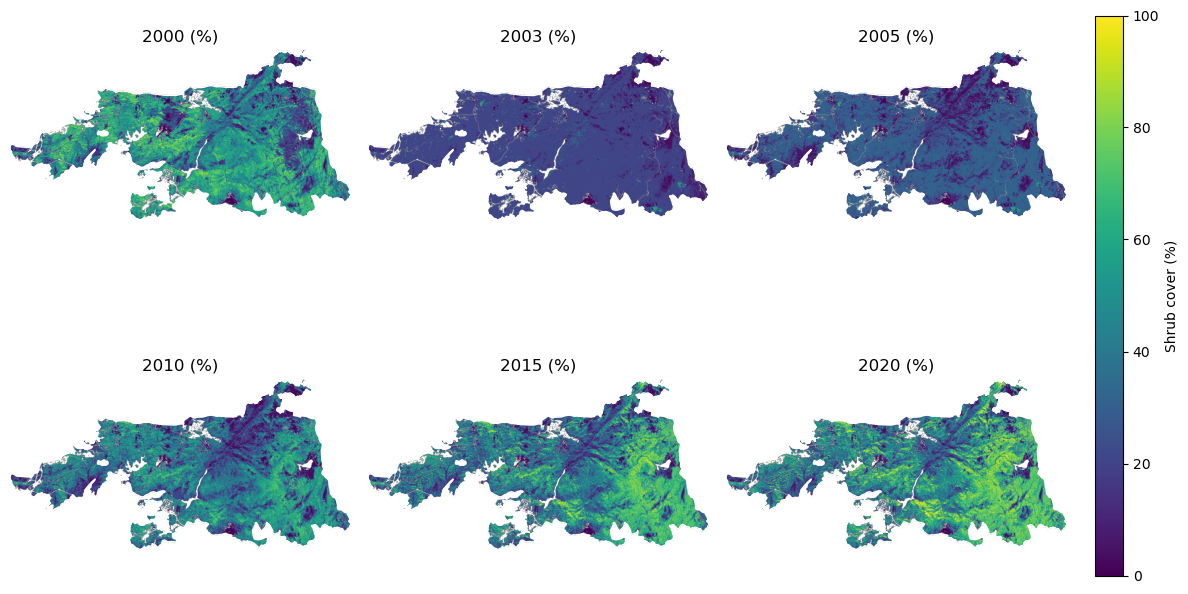

In [16]:
import matplotlib.pyplot as plt

years_to_plot = [2000, 2003, 2005, 2010, 2015, 2020]

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))

axes_flat = axes.ravel()

for ax, year in zip(axes_flat, years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(year, cedar_3310)

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band  # transform.e is negative

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap="viridis",
        extent=(left, right, bottom, top),
        origin="upper",
    )

    cedar_3310.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="white",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

# Hide any unused axes (not needed here, but safe)
for ax in axes_flat[len(years_to_plot):]:
    ax.set_visible(False)

# Manual layout: leave room on the right for the colorbar
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)

# Add a dedicated axis for the colorbar: [left, bottom, width, height] in figure coords
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

plt.show()


### Step 5.1: Create a shrub cover difference timeseries
In the plot above we have only visualized changes in shrub cover over time. To help interpret differences **within** the fire perimeter, we will take the difference between 2000 and 2020 to see if the recovery has been uniform or not. 

In [17]:
# Load 2000 and 2020 shrub arrays
band_2000, transform_2000, meta_2000 = load_and_clip_rcmap_year(2000, cedar_3310)
band_2020, transform_2020, meta_2020 = load_and_clip_rcmap_year(2020, cedar_3310)

# Make sure shapes match (they should)
print("2000 shape:", band_2000.shape)
print("2020 shape:", band_2020.shape)

# Valid pixels only (non-NaN)
valid_mask = (~np.isnan(band_2000)) & (~np.isnan(band_2020))

# Compute difference
shrub_diff = np.where(valid_mask, band_2020 - band_2000, np.nan)

# Basic stats
print("Mean change:", np.nanmean(shrub_diff))
print("Min change:", np.nanmin(shrub_diff))
print("Max change:", np.nanmax(shrub_diff))


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0

=== Loading RCMAP shrub for 2020 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_2011_2024\rcmap_shrub_2020.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 100.0
2000 shape: (1115, 2226)
2020 shape: (1115, 2226)
Mean change: 3.2742712
Min change

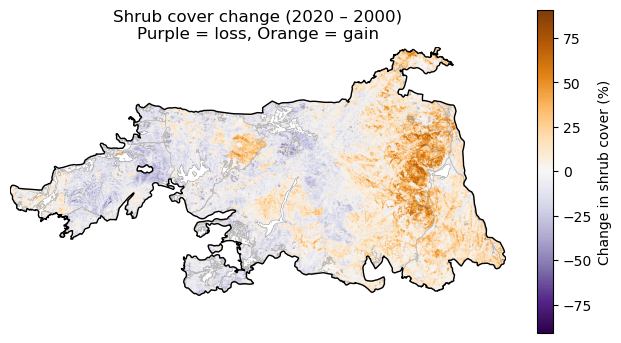

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Compute map extent
nrows, ncols = shrub_diff.shape
left = transform_2000.c
top = transform_2000.f
right = left + transform_2000.a * ncols
bottom = top + transform_2000.e * nrows

# Divergent colormap centered at 0
div_cmap = "PuOr_r"  # Purple = gain, Orange = loss

# Max absolute change for symmetric colorbar
abs_max = np.nanmax(np.abs(shrub_diff))

im = ax.imshow(
    shrub_diff,
    cmap=div_cmap,
    vmin=-abs_max,
    vmax=abs_max,
    extent=(left, right, bottom, top),
    origin="upper",
)

# Overlay Cedar perimeter
cedar_3310.to_crs(meta_2000["crs"]).boundary.plot(
    ax=ax,
    color="black",
    linewidth=1,
)

ax.set_title("Shrub cover change (2020 – 2000)\nPurple = loss, Orange = gain")
ax.set_axis_off()

# Add colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Change in shrub cover (%)")

plt.show()


### Step 5.2 Plotting histograms and cohen's d
While the maps provide a very clear picture into the land cover changes for the Cedar fire, we can also see this via the use of histograms. Histograms are helpful for "seeing" (in our case) if there is recovery skew. We visualized this in the difference map, but what if we want to know if these differences are significant? We can use histograms, divide the plot east-west and then calculate cohen's d to see if there is statistically significant differences. 

Number of valid pixels: 1138202
Mean change: 3.27 %
Median change: 1.00 %
Min change: -82.00 %
Max change: 91.00 %


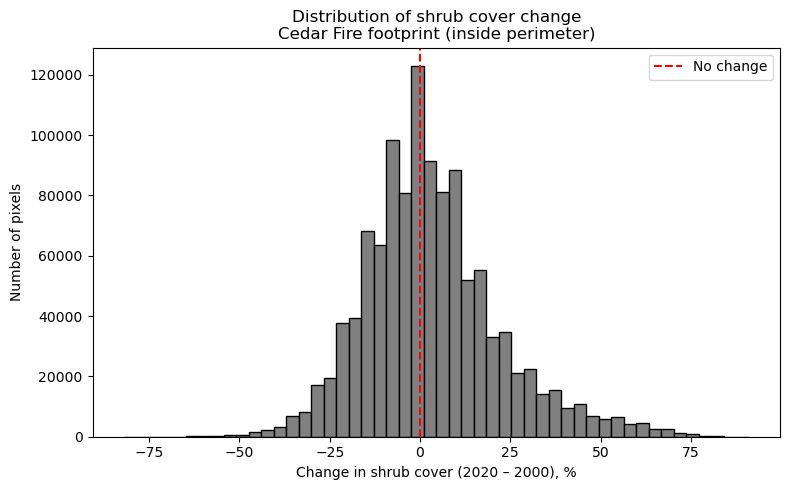

In [19]:
import matplotlib.pyplot as plt

# Flatten to 1D and keep only valid (non-NaN) pixels
valid_values = shrub_diff[~np.isnan(shrub_diff)]

print(f"Number of valid pixels: {valid_values.size}")
print(f"Mean change: {np.nanmean(valid_values):.2f} %")
print(f"Median change: {np.nanmedian(valid_values):.2f} %")
print(f"Min change: {np.nanmin(valid_values):.2f} %")
print(f"Max change: {np.nanmax(valid_values):.2f} %")

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(valid_values, bins=50, color="gray", edgecolor="black")
ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Distribution of shrub cover change\nCedar Fire footprint (inside perimeter)")
ax.legend()

plt.tight_layout()
plt.show()


### Interpreting histograms

Here the x axis is change in shrub cover (%). If we have a strong right tail (which we do), then we gained many shrub 'pixels.' The reserve also applies, if there is a strong left tail we have lost 'pixels.' 

Considering that the min and max shrub change for our plotted years from -82% and +91% respectively we have a lot of heterogeneity across the burn scar. To help look at this better, we can split the histogram east vs west, which will reveal:

- How much of the western flank truly lost shrub
- How much of the eastern flank gained shrub
- Whether the distributions are fundamentally different (spoiler: they will be given our other mapping so far)

### Step 5.3 Histogram masking for east-west differences
We will need to define a mid-point to cut the east and west divide. Once that is done, we need to specify which columns are east or west. We only need to specify the east columns as everything else will then be west by default. Once that is complete we can then plot the new east west histogram. 

In [20]:
# Compute x-coordinate array based on the geotransform
nrows, ncols = shrub_diff.shape
x_coords = transform_2000.c + np.arange(ncols) * transform_2000.a

# Midpoint defines east vs west
x_mid = np.median(x_coords)
x_mid

np.float64(-1920091.1657657186)

In [21]:
# Boolean mask: which columns are east of the midpoint?
east_mask_cols = x_coords >= x_mid
west_mask_cols = x_coords < x_mid

# Expand masks to match raster shape (rows x cols)
east_mask = np.tile(east_mask_cols, (nrows, 1))
west_mask = np.tile(west_mask_cols, (nrows, 1))


In [22]:
# Apply geographic masks AND valid-data mask
valid_mask = ~np.isnan(shrub_diff)

east_values = shrub_diff[east_mask & valid_mask]
west_values = shrub_diff[west_mask & valid_mask]

print("East pixels:", east_values.size)
print("West pixels:", west_values.size)
print("East mean change:", np.nanmean(east_values))
print("West mean change:", np.nanmean(west_values))


East pixels: 758151
West pixels: 380051
East mean change: 8.012434
West mean change: -6.1777315


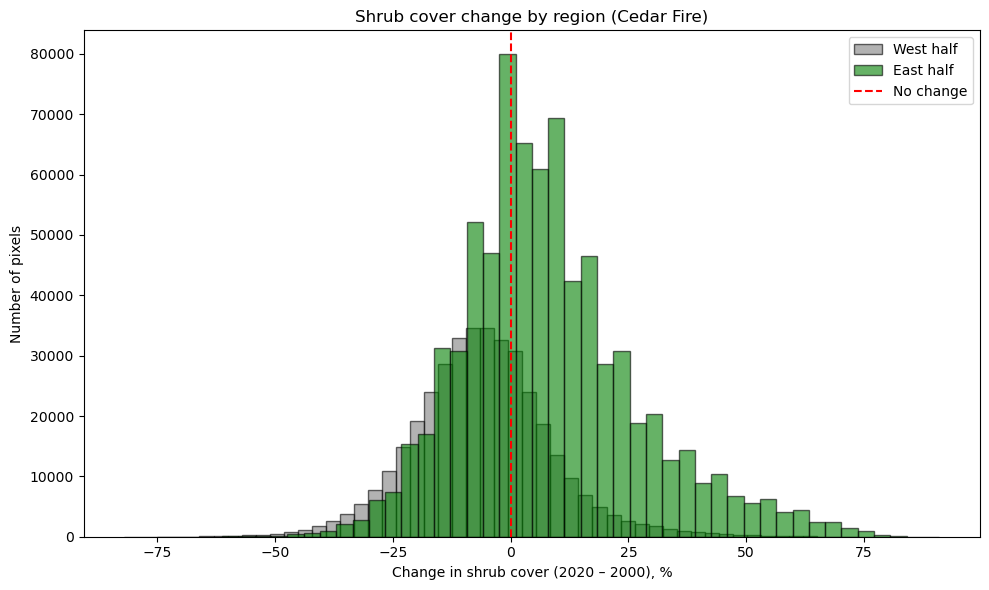

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bins = 50

ax.hist(
    west_values,
    bins=bins,
    alpha=0.6,
    color="gray",
    edgecolor="black",
    label="West half"
)

ax.hist(
    east_values,
    bins=bins,
    alpha=0.6,
    color="green",   # safe shade for most colorblind viewers
    edgecolor="black",
    label="East half"
)

ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Shrub cover change by region (Cedar Fire)")
ax.legend()

plt.tight_layout()
plt.show()


With the new histogram we can see a more bimodal pattern of shrub recovery for the Cedar fire. This is what scientists mean when they say a disturbance can create bimodal recovery regimes.

### Interpretation of East–West Recovery Differences

The comparison of shrub-cover change between 2000 and 2020 shows that the Cedar Fire produced two distinct post-fire recovery regimes within its perimeter. Spatial patterns in the change map suggest that the east side experienced strong shrub regeneration, with many pixels gaining substantial shrub cover, while the west side shows widespread reductions or minimal recovery. The histogram analysis confirms this visual pattern: the east distribution is shifted strongly toward shrub gains (to the right and positive), whereas the west distribution centers near or below zero, with a much weaker right tail indicating poorer shrub recovery over the 17 years since the fire. Together, these results reveal a highly heterogeneous post-fire landscape in which the eastern portion followed a classic chaparral rebound trajectory, while the western portion appears to have recovered more slowly, potentially reflecting higher burn severity, environmental gradients, or long-term vegetation change. We would need other data to actually know why there is a such a split between the west and east with shrub coverage. 

### Step 5.4 Calculating cohen's d
Now that we know there is a bimodal distribution, we can use cohen's d with the east and west values. Here we will calculate the pooled standard deviation of the east and west values. Afterwards we can calculate cohen's d by subtracting the east and west values and dividing this over our pooled standard deviation. 

In [24]:
import numpy as np

# Standard deviations
sd_east = np.nanstd(east_values, ddof=1)
sd_west = np.nanstd(west_values, ddof=1)

# Sample sizes
n_east = len(east_values)
n_west = len(west_values)

# Pooled standard deviation
pooled_sd = np.sqrt(
    (((n_east - 1) * sd_east**2) + ((n_west - 1) * sd_west**2)) / (n_east + n_west - 2)
)

# Cohen's d
cohens_d = (np.nanmean(east_values) - np.nanmean(west_values)) / pooled_sd

cohens_d


np.float32(0.802005)

| Cohen’s d   | Interpretation                       |
| ----------- | ------------------------------------ |
| **0.2**     | small difference                     |
| **0.5**     | moderate difference                  |
| **0.8**     | **large difference**                 |
| **1.0–1.5** | very large ecological divergence |
| **> 2.0**   | ecosystems behaving differently      |

### A Cohen’s d of 0.8 indicates a large difference between the east and west distributions of shrub-cover change. In practical terms, this means:

- The east side of the Cedar Fire perimeter experienced substantially greater shrub recovery than the west side.
- Even after accounting for natural variability across the landscape (captured by the pooled standard deviation), the mean difference (~14 percentage points) represents a strong ecological divergence.
- A d of 0.80 is high enough to indicate that these two areas are recovering along distinct post-fire trajectories, not just random variation around a shared pattern.
- Ecologically, this points to persistent differences in burn severity, species composition (e.g., resprouter dominance in the east), microsite conditions, or post-fire disturbance that created two vegetation regimes within the same fire scar.

In other words:

- The east half of the Cedar Fire is recovering as robust chaparral, while the west half shows evidence of reduced shrub recovery — possibly slowed regeneration or partial type conversion.

# Ramonians were right: after the Cedar fire areas did not recover: 
Although shrub cover dropped to near-zero across the entire Cedar Fire footprint in 2003 and remained extremely low in 2005—indicating that both the eastern and western portions of the landscape experienced similarly severe shrub loss—the subsequent recovery patterns diverged sharply. By 2020, the eastern half showed strong shrub regeneration and in many areas exceeded pre-fire levels, while the western half recovered much more slowly and in places exhibited persistent shrub loss. This difference is quantified by a Cohen’s d of 0.80, a large effect size, indicating that the east and west sides of the fire scar now represent distinct ecological trajectories rather than variations around a shared recovery pattern. The result suggests that even though both regions were equally impacted by the initial disturbance, differences in burn severity, microclimate, species composition, or post-fire disturbance produced a long-term bifurcation in vegetation dynamics.

### Step 6: Save plots/figures

In [25]:
# Use the existing FIG_DIR and just add a subfolder for landcover
LANDCOVER_FIG_DIR = FIG_DIR / "landcover"
LANDCOVER_FIG_DIR.mkdir(parents=True, exist_ok=True)

LANDCOVER_FIG_DIR

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover')


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 94.0

=== Loading RCMAP shrub for 2003 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2003.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1115, 2226)
Min shrub % (0–100): 0.0
Max shrub % (0–100): 84.0

=== Loading RCMAP shrub for 2005 ===
Using file: C:\Users\kayle\Desktop\earth-analy

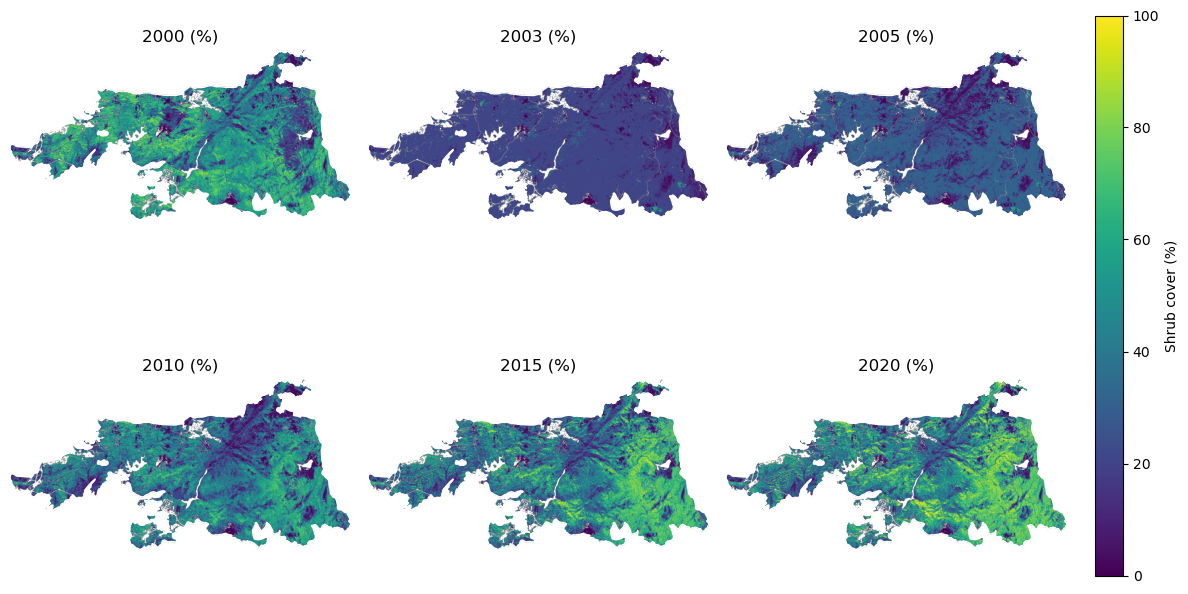

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/cedar_shrub_cover_maps_2000_2020.png')

In [26]:
import matplotlib.pyplot as plt

years_to_plot = [2000, 2003, 2005, 2010, 2015, 2020]

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes_flat = axes.ravel()

for ax, year in zip(axes_flat, years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(year, cedar_3310)

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band  # transform.e is negative

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap="viridis",
        extent=(left, right, bottom, top),
        origin="upper",
    )

    cedar_3310.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="white",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

# Hide any unused axes (safety)
for ax in axes_flat[len(years_to_plot):]:
    ax.set_visible(False)

# Manual layout for shared colorbar
fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

# Save + show
cedar_maps_path = LANDCOVER_FIG_DIR / "cedar_shrub_cover_maps_2000_2020.png"
fig.savefig(cedar_maps_path, dpi=300)
plt.show()

cedar_maps_path


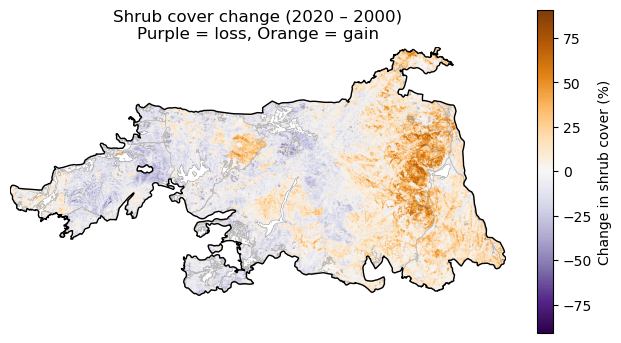

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/cedar_shrub_change_2020_minus_2000.png')

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

nrows_diff, ncols_diff = shrub_diff.shape
left = transform_2000.c
top = transform_2000.f
right = left + transform_2000.a * ncols_diff
bottom = top + transform_2000.e * nrows_diff

abs_max = np.nanmax(np.abs(shrub_diff))

im = ax.imshow(
    shrub_diff,
    cmap="PuOr_r",  # or your chosen diverging cmap
    vmin=-abs_max,
    vmax=abs_max,
    extent=(left, right, bottom, top),
    origin="upper",
)

cedar_3310.to_crs(meta_2000["crs"]).boundary.plot(
    ax=ax,
    color="black",
    linewidth=1,
)

ax.set_title("Shrub cover change (2020 – 2000)\nPurple = loss, Orange = gain")
ax.set_axis_off()

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Change in shrub cover (%)")

cedar_change_map_path = LANDCOVER_FIG_DIR / "cedar_shrub_change_2020_minus_2000.png"
fig.savefig(cedar_change_map_path, dpi=300, bbox_inches="tight")
plt.show()

cedar_change_map_path


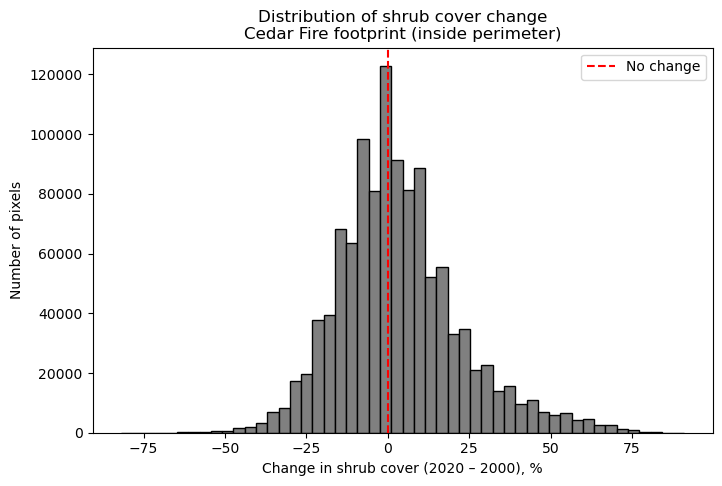

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/cedar_shrub_change_hist_overall.png')

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

valid_values = shrub_diff[~np.isnan(shrub_diff)]

ax.hist(valid_values, bins=50, color="gray", edgecolor="black")
ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Distribution of shrub cover change\nCedar Fire footprint (inside perimeter)")
ax.legend()

cedar_hist_overall_path = LANDCOVER_FIG_DIR / "cedar_shrub_change_hist_overall.png"
fig.savefig(cedar_hist_overall_path, dpi=300, bbox_inches="tight")
plt.show()

cedar_hist_overall_path


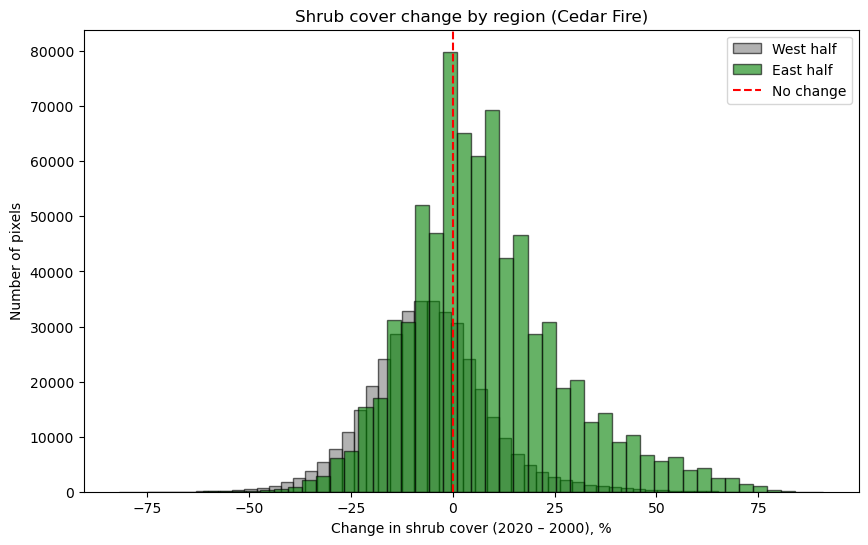

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/cedar_shrub_change_hist_east_vs_west.png')

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = 50

ax.hist(
    west_values,
    bins=bins,
    alpha=0.6,
    color="gray",
    edgecolor="black",
    label="West half",
)

ax.hist(
    east_values,
    bins=bins,
    alpha=0.6,
    color="green",
    edgecolor="black",
    label="East half",
)

ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Shrub cover change by region (Cedar Fire)")
ax.legend()

cedar_hist_east_west_path = LANDCOVER_FIG_DIR / "cedar_shrub_change_hist_east_vs_west.png"
fig.savefig(cedar_hist_east_west_path, dpi=300, bbox_inches="tight")
plt.show()

cedar_hist_east_west_path


In [30]:
processed_dir = DATA_DIR / "processed" / "landcover"
processed_dir.mkdir(parents=True, exist_ok=True)

# Time series CSV
cedar_csv_path = processed_dir / "cedar_shrub_cover_time.csv"
cedar_shrub_df.to_csv(cedar_csv_path, index=True)

cedar_csv_path


WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/processed/landcover/cedar_shrub_cover_time.csv')

In [31]:
cedar_summary_path = processed_dir / "cedar_shrub_change_east_west_summary.csv"

summary_records = [
    {
        "region": "east",
        "n_pixels": len(east_values),
        "mean_change": float(np.nanmean(east_values)),
        "median_change": float(np.nanmedian(east_values)),
        "std_change": float(np.nanstd(east_values, ddof=1)),
    },
    {
        "region": "west",
        "n_pixels": len(west_values),
        "mean_change": float(np.nanmean(west_values)),
        "median_change": float(np.nanmedian(west_values)),
        "std_change": float(np.nanstd(west_values, ddof=1)),
    },
]

cedar_summary_df = pd.DataFrame.from_records(summary_records)
cedar_summary_df["cohens_d_east_minus_west"] = float(cohens_d)

cedar_summary_df.to_csv(cedar_summary_path, index=False)

cedar_summary_df, cedar_summary_path


(  region  n_pixels  mean_change  median_change  std_change  \
 0   east    758151     8.012434            5.0   19.023054   
 1   west    380051    -6.177732           -6.0   14.685453   
 
    cohens_d_east_minus_west  
 0                  0.802005  
 1                  0.802005  ,
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/processed/landcover/cedar_shrub_change_east_west_summary.csv'))

In [32]:

# Where to save processed files
processed_dir = DATA_DIR / "processed" / "landcover"
processed_dir.mkdir(parents=True, exist_ok=True)

# ---------------------------
# 1. Save the cedar time-series CSV (already done earlier)
# ---------------------------
cedar_time_csv = processed_dir / "cedar_shrub_cover_time.csv"
cedar_shrub_df.to_csv(cedar_time_csv, index=True)

# ---------------------------
# 2. Save east–west summary CSV
# ---------------------------
cedar_summary_csv = processed_dir / "cedar_shrub_change_east_west_summary.csv"

summary_records = [
    {
        "region": "east",
        "n_pixels": len(east_values),
        "mean_change": float(np.nanmean(east_values)),
        "median_change": float(np.nanmedian(east_values)),
        "std_change": float(np.nanstd(east_values, ddof=1)),
    },
    {
        "region": "west",
        "n_pixels": len(west_values),
        "mean_change": float(np.nanmean(west_values)),
        "median_change": float(np.nanmedian(west_values)),
        "std_change": float(np.nanstd(west_values, ddof=1)),
    },
]

cedar_summary_df = pd.DataFrame(summary_records)
cedar_summary_df["cohens_d_east_minus_west"] = float(cohens_d)
cedar_summary_df.to_csv(cedar_summary_csv, index=False)

# ---------------------------
# 3. Save core numerical arrays for reuse
# ---------------------------
cedar_arrays_npz = processed_dir / "cedar_core_arrays.npz"

np.savez(
    cedar_arrays_npz,
    shrub_diff=shrub_diff,
    east_values=east_values,
    west_values=west_values,
    east_mask=east_mask,
    west_mask=west_mask,
    transform_2000=np.array(transform_2000),  # store geotransform
    transform_2020=np.array(transform_2020),
    cedar_bounds=np.array(cedar_3310.total_bounds),
    cohens_d=float(cohens_d),
)

# ---------------------------
# 4. Print summary for user clarity
# ---------------------------
print("Stored variables for Cedar Fire analysis:")
print(f"- Time series CSV: {cedar_time_csv}")
print(f"- East–west summary CSV: {cedar_summary_csv}")
print(f"- Core arrays NPZ: {cedar_arrays_npz}")


Stored variables for Cedar Fire analysis:
- Time series CSV: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\cedar_shrub_cover_time.csv
- East–west summary CSV: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\cedar_shrub_change_east_west_summary.csv
- Core arrays NPZ: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\cedar_core_arrays.npz


### Step 7: Store values
Remember you can use %whos to see what variables there are instead of scaning the entire notebook.

In [33]:
%whos

Variable                         Type            Data/Info
----------------------------------------------------------
BOUNDARY_DIR                     WindowsPath     C:\Users\kayle\Desktop\ea<...>-recovery\data\boundaries
CEDAR_YEARS                      dict            n=3
DATA_DIR                         WindowsPath     C:\Users\kayle\Desktop\ea<...>ramona-fire-recovery\data
FIG_DIR                          WindowsPath     C:\Users\kayle\Desktop\ea<...>ona-fire-recovery\figures
LANDCOVER_DIR                    WindowsPath     C:\Users\kayle\Desktop\ea<...>covery\data\raw\landcover
LANDCOVER_FIG_DIR                WindowsPath     C:\Users\kayle\Desktop\ea<...>ecovery\figures\landcover
MRLC_BASE                        str             https://www.mrlc.gov
NLCD_CLASSES                     dict            n=17
PROJECT_ROOT                     WindowsPath     C:\Users\kayle\Desktop\ea<...>ject\ramona-fire-recovery
Path                             type            <class 'pathlib.Path'>
RCM

In [ ]:
%store LANDCOVER_DIR LANDCOVER_FIG_DIR RCMAP_ZIP_DIR RCMAP_SHRUB_DIR cedar_shrub_maps cedar_shrub_df 

Stored 'LANDCOVER_DIR' (WindowsPath)
Stored 'LANDCOVER_FIG_DIR' (WindowsPath)
Stored 'RCMAP_ZIP_DIR' (WindowsPath)
Stored 'RCMAP_SHRUB_DIR' (WindowsPath)
Stored 'cedar_shrub_maps' (dict)
Stored 'cedar_shrub_df' (DataFrame)
